In [1]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
from PIL import Image
import imgaug

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

from pycocotools.coco import COCO
from pycocotools import mask as maskUtils

Using TensorFlow backend.


In [2]:
class BuildingConfig(Config):
    """Configuration for training on data in MS COCO format.
    Derives from the base Config class and overrides values specific
    to the COCO dataset.
    """
    # Give the configuration a recognizable name
    NAME = "OSM_buildingdetector"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you get "ResourceExhaustedError" while running training
    IMAGES_PER_GPU = 2

    # Uncomment to train on 8 GPUs (default is 1)
    GPU_COUNT = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # 1 Backgroun + 1 Building

    STEPS_PER_EPOCH=1000
    VALIDATION_STEPS=50


    IMAGE_MAX_DIM=320
    IMAGE_MIN_DIM=320

config = BuildingConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  320
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  320
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [320 320   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [3]:
############################################################
#  Dataset
############################################################

class BuildingDataset(utils.Dataset):
    def load_buildings(self, dataset_dir, load_small=False, return_coco=True):
        """ Loads dataset released for the crowdAI Mapping Challenge(https://www.crowdai.org/challenges/mapping-challenge)
            Params:
                - dataset_dir : root directory of the dataset (can point to the train/val folder)
                - load_small : Boolean value which signals if the annotations for all the images need to be loaded into the memory,
                               or if only a small subset of the same should be loaded into memory
        """
        self.load_small = load_small
        if self.load_small:
            annotation_path = os.path.join(dataset_dir, "annotation-small.json")
        else:
            annotation_path = os.path.join(dataset_dir, "annotation.json")

        image_dir = os.path.join(dataset_dir, "images")
        print("Annotation Path ", annotation_path)
        print("Image Dir ", image_dir)
        assert os.path.exists(annotation_path) and os.path.exists(image_dir)

        self.coco = COCO(annotation_path)
        self.image_dir = image_dir

        # Load all classes (Only Building in this version)
        classIds = self.coco.getCatIds()

        # Load all images
        image_ids = list(self.coco.imgs.keys())

        # register classes
        for _class_id in classIds:
            self.add_class("crowdai-mapping-challenge", _class_id, self.coco.loadCats(_class_id)[0]["name"])

        # Register Images
        for _img_id in image_ids:
            assert(os.path.exists(os.path.join(image_dir, self.coco.imgs[_img_id]['file_name'])))
            self.add_image(
                "crowdai-mapping-challenge", image_id=_img_id,
                path=os.path.join(image_dir, self.coco.imgs[_img_id]['file_name']),
                width=self.coco.imgs[_img_id]["width"],
                height=self.coco.imgs[_img_id]["height"],
                annotations=self.coco.loadAnns(self.coco.getAnnIds(
                                            imgIds=[_img_id],
                                            catIds=classIds,
                                            iscrowd=None)))

        if return_coco:
            return self.coco

    def load_mask(self, image_id):
        """ Loads instance mask for a given image
              This function converts mask from the coco format to a
              a bitmap [height, width, instance]
            Params:
                - image_id : reference id for a given image

            Returns:
                masks : A bool array of shape [height, width, instances] with
                    one mask per instance
                class_ids : a 1D array of classIds of the corresponding instance masks
                    (In this version of the challenge it will be of shape [instances] and always be filled with the class-id of the "Building" class.)
        """

        image_info = self.image_info[image_id]
        assert image_info["source"] == "crowdai-mapping-challenge"

        instance_masks = []
        class_ids = []
        annotations = self.image_info[image_id]["annotations"]
        # Build mask of shape [height, width, instance_count] and list
        # of class IDs that correspond to each channel of the mask.
        for annotation in annotations:
            class_id = self.map_source_class_id(
                "crowdai-mapping-challenge.{}".format(annotation['category_id']))
            if class_id:
                m = self.annToMask(annotation,  image_info["height"],
                                                image_info["width"])
                # Some objects are so small that they're less than 1 pixel area
                # and end up rounded out. Skip those objects.
                if m.max() < 1:
                    continue

                # Ignore the notion of "is_crowd" as specified in the coco format
                # as we donot have the said annotation in the current version of the dataset

                instance_masks.append(m)
                class_ids.append(class_id)
        # Pack instance masks into an array
        if class_ids:
            mask = np.stack(instance_masks, axis=2)
            class_ids = np.array(class_ids, dtype=np.int32)
            return mask, class_ids
        else:
            # Call super class to return an empty mask
            return super(BuildingDataset, self).load_mask(image_id)


    def image_reference(self, image_id):
        """Return a reference for a particular image

            Ideally you this function is supposed to return a URL
            but in this case, we will simply return the image_id
        """
        return "crowdai-mapping-challenge::{}".format(image_id)
    # The following two functions are from pycocotools with a few changes.

    def annToRLE(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE to RLE.
        :return: binary mask (numpy 2D array)
        """
        segm = ann['segmentation']
        if isinstance(segm, list):
            # polygon -- a single object might consist of multiple parts
            # we merge all parts into one mask rle code
            rles = maskUtils.frPyObjects(segm, height, width)
            rle = maskUtils.merge(rles)
        elif isinstance(segm['counts'], list):
            # uncompressed RLE
            rle = maskUtils.frPyObjects(segm, height, width)
        else:
            # rle
            rle = ann['segmentation']
        return rle

    def annToMask(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
        :return: binary mask (numpy 2D array)
        """
        rle = self.annToRLE(ann, height, width)
        m = maskUtils.decode(rle)
        return m

In [4]:
# Train dataset
data_dir = '../../building_data/dataset2/'
dataset_train = BuildingDataset()
dataset_train.load_buildings(data_dir + "train")
dataset_train.prepare()

# Validation dataset
dataset_val = BuildingDataset()
dataset_val.load_buildings(data_dir + "val")
dataset_val.prepare()

Annotation Path  ../../building_data/dataset2/train/annotation.json
Image Dir  ../../building_data/dataset2/train/images
loading annotations into memory...
Done (t=29.00s)
creating index...
index created!
Annotation Path  ../../building_data/dataset2/val/annotation.json
Image Dir  ../../building_data/dataset2/val/images
loading annotations into memory...
Done (t=7.37s)
creating index...
index created!


In [5]:
dataset_train.class_info

[{'source': '', 'id': 0, 'name': 'BG'},
 {'source': 'crowdai-mapping-challenge', 'id': 100, 'name': 'building'}]

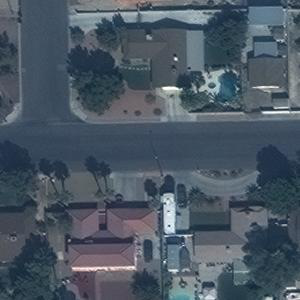

In [6]:
Image.open(dataset_train.image_info[2]['path'])

In [6]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

In [8]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, last, or pretrained

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)
    
elif init_with == "pretrained":
    model.load_weights(os.path.join(ROOT_DIR, "logs/pretrained_weights.h5"), by_name=True)

Re-starting from epoch 77


In [10]:
import warnings
warnings.filterwarnings('ignore')

In [86]:
# *** This training schedule is an example. Update to your needs ***

# Training - Stage 1
# model.train(dataset_train, dataset_val,
#             learning_rate=config.LEARNING_RATE/10,
#             epochs=5,
#             layers='heads')

# Training - Stage 2
# model.train(dataset_train, dataset_val,
#             learning_rate=config.LEARNING_RATE/10,
#             epochs=10,
#             layers='4+')

# model.train(dataset_train, dataset_val,
#             learning_rate=config.LEARNING_RATE/10,
#             epochs=15,
#             layers='all')

# model.train(dataset_train, dataset_val,
#             learning_rate=config.LEARNING_RATE/20,
#             epochs=20,
#             layers='heads')


Starting at epoch 15. LR=5e-05

Checkpoint Path: /home/jupyter/research/Mask_RCNN/Mask_RCNN/logs/osm_buildingdetector20190722T2306/mask_rcnn_osm_buildingdetector_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
m

 320/1000 [========>.....................] - ETA: 10:54 - loss: 1.2347 - rpn_class_loss: 0.0954 - rpn_bbox_loss: 0.6527 - mrcnn_class_loss: 0.0860 - mrcnn_bbox_loss: 0.1638 - mrcnn_mask_loss: 0.2368

 324/1000 [========>.....................] - ETA: 10:51 - loss: 1.2442 - rpn_class_loss: 0.0972 - rpn_bbox_loss: 0.6589 - mrcnn_class_loss: 0.0870 - mrcnn_bbox_loss: 0.1640 - mrcnn_mask_loss: 0.2372

 325/1000 [========>.....................] - ETA: 10:50 - loss: 1.2430 - rpn_class_loss: 0.0971 - rpn_bbox_loss: 0.6577 - mrcnn_class_loss: 0.0869 - mrcnn_bbox_loss: 0.1641 - mrcnn_mask_loss: 0.2373

 326/1000 [========>.....................] - ETA: 10:49 - loss: 1.2420 - rpn_class_loss: 0.0969 - rpn_bbox_loss: 0.6564 - mrcnn_class_loss: 0.0869 - mrcnn_bbox_loss: 0.1643 - mrcnn_mask_loss: 0.2374

 330/1000 [========>.....................] - ETA: 10:45 - loss: 1.2472 - rpn_class_loss: 0.0979 - rpn_bbox_loss: 0.6593 - mrcnn_class_loss: 0.0876 - mrcnn_bbox_loss: 0.1646 - mrcnn_mask_loss: 0.2378

 331/1000 [========>.....................] - ETA: 10:44 - loss: 1.2460 - rpn_class_loss: 0.0978 - rpn_bbox_loss: 0.6581 - mrcnn_class_loss: 0.0875 - mrcnn_bbox_loss: 0.1647 - mrcnn_mask_loss: 0.2379

 337/1000 [=========>....................] - ETA: 10:38 - loss: 1.2453 - rpn_class_loss: 0.0975 - rpn_bbox_loss: 0.6569 - mrcnn_class_loss: 0.0876 - mrcnn_bbox_loss: 0.1652 - mrcnn_mask_loss: 0.2382

1000/1000 [==============================] - 984s 984ms/step - loss: 1.3045 - rpn_class_loss: 0.1073 - rpn_bbox_loss: 0.7019 - mrcnn_class_loss: 0.0860 - mrcnn_bbox_loss: 0.1675 - mrcnn_mask_loss: 0.2418 - val_loss: 1.2090 - val_rpn_class_loss: 0.1155 - val_rpn_bbox_loss: 0.6414 - val_mrcnn_class_loss: 0.0793 - val_mrcnn_bbox_loss: 0.1518 - val_mrcnn_mask_loss: 0.2210
Epoch 18/20
1000/1000 [==============================] - 994s 994ms/step - loss: 1.3196 - rpn_class_loss: 0.1119 - rpn_bbox_loss: 0.7249 - mrcnn_class_loss: 0.0884 - mrcnn_bbox_loss: 0.1588 - mrcnn_mask_loss: 0.2356 - val_loss: 1.2028 - val_rpn_class_loss: 0.1127 - val_rpn_bbox_loss: 0.5951 - val_mrcnn_class_loss: 0.0889 - val_mrcnn_bbox_loss: 0.1632 - val_mrcnn_mask_loss: 0.2429
Epoch 19/20
1000/1000 [==============================] - 993s 993ms/step - loss: 1.2562 - rpn_class_loss: 0.1029 - rpn_bbox_loss: 0.6590 - mrcnn_class_loss: 0.0849 - mrcnn_bbox_loss: 0.1669 - mrcnn_mask_loss: 0.2425 - val_loss: 1.7909 - val_rpn_c

In [11]:
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE/20,
            epochs=25,
            layers='4+')


Starting at epoch 20. LR=5e-05

Checkpoint Path: /home/jupyter/research/Mask_RCNN/Mask_RCNN/logs/osm_buildingdetector20190722T2306/mask_rcnn_osm_buildingdetector_{epoch:04d}.h5
Selecting layers to train
res4a_branch2a         (Conv2D)
bn4a_branch2a          (BatchNorm)
res4a_branch2b         (Conv2D)
bn4a_branch2b          (BatchNorm)
res4a_branch2c         (Conv2D)
res4a_branch1          (Conv2D)
bn4a_branch2c          (BatchNorm)
bn4a_branch1           (BatchNorm)
res4b_branch2a         (Conv2D)
bn4b_branch2a          (BatchNorm)
res4b_branch2b         (Conv2D)
bn4b_branch2b          (BatchNorm)
res4b_branch2c         (Conv2D)
bn4b_branch2c          (BatchNorm)
res4c_branch2a         (Conv2D)
bn4c_branch2a          (BatchNorm)
res4c_branch2b         (Conv2D)
bn4c_branch2b          (BatchNorm)
res4c_branch2c         (Conv2D)
bn4c_branch2c          (BatchNorm)
res4d_branch2a         (Conv2D)
bn4d_branch2a          (BatchNorm)
res4d_branch2b         (Conv2D)
bn4d_branch2b          (Bat

In [12]:
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE/20,
            epochs=30,
            layers='all')


Starting at epoch 25. LR=5e-05

Checkpoint Path: /home/jupyter/research/Mask_RCNN/Mask_RCNN/logs/osm_buildingdetector20190722T2306/mask_rcnn_osm_buildingdetector_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (Bat

Epoch 26/30
1000/1000 [==============================] - 840s 840ms/step - loss: 1.0837 - rpn_class_loss: 0.0883 - rpn_bbox_loss: 0.5501 - mrcnn_class_loss: 0.0777 - mrcnn_bbox_loss: 0.1336 - mrcnn_mask_loss: 0.2340 - val_loss: 1.3388 - val_rpn_class_loss: 0.0756 - val_rpn_bbox_loss: 0.7471 - val_mrcnn_class_loss: 0.0689 - val_mrcnn_bbox_loss: 0.1675 - val_mrcnn_mask_loss: 0.2797
Epoch 27/30
1000/1000 [==============================] - 801s 801ms/step - loss: 0.9649 - rpn_class_loss: 0.0704 - rpn_bbox_loss: 0.4605 - mrcnn_class_loss: 0.0727 - mrcnn_bbox_loss: 0.1303 - mrcnn_mask_loss: 0.2311 - val_loss: 1.1274 - val_rpn_class_loss: 0.1012 - val_rpn_bbox_loss: 0.4554 - val_mrcnn_class_loss: 0.1149 - val_mrcnn_bbox_loss: 0.1721 - val_mrcnn_mask_loss: 0.2838
Epoch 28/30
1000/1000 [==============================] - 801s 801ms/step - loss: 0.9292 - rpn_class_loss: 0.0677 - rpn_bbox_loss: 0.4403 - mrcnn_class_loss: 0.0747 - mrcnn_bbox_loss: 0.1197 - mrcnn_mask_loss: 0.2267 - val_loss: 1.8111

In [13]:
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE/20,
            epochs=35,
            layers='heads')


Starting at epoch 30. LR=5e-05

Checkpoint Path: /home/jupyter/research/Mask_RCNN/Mask_RCNN/logs/osm_buildingdetector20190722T2306/mask_rcnn_osm_buildingdetector_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
m

In [14]:
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE/20,
            epochs=40,
            layers='4+')


Starting at epoch 35. LR=5e-05

Checkpoint Path: /home/jupyter/research/Mask_RCNN/Mask_RCNN/logs/osm_buildingdetector20190722T2306/mask_rcnn_osm_buildingdetector_{epoch:04d}.h5
Selecting layers to train
res4a_branch2a         (Conv2D)
bn4a_branch2a          (BatchNorm)
res4a_branch2b         (Conv2D)
bn4a_branch2b          (BatchNorm)
res4a_branch2c         (Conv2D)
res4a_branch1          (Conv2D)
bn4a_branch2c          (BatchNorm)
bn4a_branch1           (BatchNorm)
res4b_branch2a         (Conv2D)
bn4b_branch2a          (BatchNorm)
res4b_branch2b         (Conv2D)
bn4b_branch2b          (BatchNorm)
res4b_branch2c         (Conv2D)
bn4b_branch2c          (BatchNorm)
res4c_branch2a         (Conv2D)
bn4c_branch2a          (BatchNorm)
res4c_branch2b         (Conv2D)
bn4c_branch2b          (BatchNorm)
res4c_branch2c         (Conv2D)
bn4c_branch2c          (BatchNorm)
res4d_branch2a         (Conv2D)
bn4d_branch2a          (BatchNorm)
res4d_branch2b         (Conv2D)
bn4d_branch2b          (Bat

In [15]:
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE/20,
            epochs=45,
            layers='all')


Starting at epoch 40. LR=5e-05

Checkpoint Path: /home/jupyter/research/Mask_RCNN/Mask_RCNN/logs/osm_buildingdetector20190722T2306/mask_rcnn_osm_buildingdetector_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (Bat

Epoch 41/45
1000/1000 [==============================] - 860s 860ms/step - loss: 0.7114 - rpn_class_loss: 0.0453 - rpn_bbox_loss: 0.3231 - mrcnn_class_loss: 0.0535 - mrcnn_bbox_loss: 0.0823 - mrcnn_mask_loss: 0.2072 - val_loss: 1.7083 - val_rpn_class_loss: 0.1012 - val_rpn_bbox_loss: 1.0607 - val_mrcnn_class_loss: 0.0703 - val_mrcnn_bbox_loss: 0.1719 - val_mrcnn_mask_loss: 0.3043
Epoch 42/45
1000/1000 [==============================] - 815s 815ms/step - loss: 0.6371 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.2709 - mrcnn_class_loss: 0.0500 - mrcnn_bbox_loss: 0.0769 - mrcnn_mask_loss: 0.2020 - val_loss: 1.8005 - val_rpn_class_loss: 0.1573 - val_rpn_bbox_loss: 0.9399 - val_mrcnn_class_loss: 0.1442 - val_mrcnn_bbox_loss: 0.2258 - val_mrcnn_mask_loss: 0.3333
Epoch 43/45
1000/1000 [==============================] - 814s 814ms/step - loss: 0.6211 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.2647 - mrcnn_class_loss: 0.0521 - mrcnn_bbox_loss: 0.0708 - mrcnn_mask_loss: 0.1994 - val_loss: 2.2695

In [16]:
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE/50,
            epochs=50,
            layers='heads')


Starting at epoch 45. LR=2e-05

Checkpoint Path: /home/jupyter/research/Mask_RCNN/Mask_RCNN/logs/osm_buildingdetector20190722T2306/mask_rcnn_osm_buildingdetector_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
m

In [17]:
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE/50,
            epochs=55,
            layers='4+')


Starting at epoch 50. LR=2e-05

Checkpoint Path: /home/jupyter/research/Mask_RCNN/Mask_RCNN/logs/osm_buildingdetector20190722T2306/mask_rcnn_osm_buildingdetector_{epoch:04d}.h5
Selecting layers to train
res4a_branch2a         (Conv2D)
bn4a_branch2a          (BatchNorm)
res4a_branch2b         (Conv2D)
bn4a_branch2b          (BatchNorm)
res4a_branch2c         (Conv2D)
res4a_branch1          (Conv2D)
bn4a_branch2c          (BatchNorm)
bn4a_branch1           (BatchNorm)
res4b_branch2a         (Conv2D)
bn4b_branch2a          (BatchNorm)
res4b_branch2b         (Conv2D)
bn4b_branch2b          (BatchNorm)
res4b_branch2c         (Conv2D)
bn4b_branch2c          (BatchNorm)
res4c_branch2a         (Conv2D)
bn4c_branch2a          (BatchNorm)
res4c_branch2b         (Conv2D)
bn4c_branch2b          (BatchNorm)
res4c_branch2c         (Conv2D)
bn4c_branch2c          (BatchNorm)
res4d_branch2a         (Conv2D)
bn4d_branch2a          (BatchNorm)
res4d_branch2b         (Conv2D)
bn4d_branch2b          (Bat

In [ ]:
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE/50,
            epochs=60,
            layers='all')


Starting at epoch 59. LR=2e-05

Checkpoint Path: /home/jupyter/research/Mask_RCNN/Mask_RCNN/logs/osm_buildingdetector20190722T2306/mask_rcnn_osm_buildingdetector_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (Bat

Instructions for updating:
Use tf.cast instead.
Epoch 60/60
 252/1000 [======>.......................] - ETA: 11:58 - loss: 1.5674 - rpn_class_loss: 0.1380 - rpn_bbox_loss: 0.8313 - mrcnn_class_loss: 0.1340 - mrcnn_bbox_loss: 0.1755 - mrcnn_mask_loss: 0.2886

 256/1000 [======>.......................] - ETA: 11:52 - loss: 1.5826 - rpn_class_loss: 0.1387 - rpn_bbox_loss: 0.8402 - mrcnn_class_loss: 0.1367 - mrcnn_bbox_loss: 0.1776 - mrcnn_mask_loss: 0.2894

 259/1000 [======>.......................] - ETA: 11:48 - loss: 1.5872 - rpn_class_loss: 0.1385 - rpn_bbox_loss: 0.8420 - mrcnn_class_loss: 0.1381 - mrcnn_bbox_loss: 0.1787 - mrcnn_mask_loss: 0.2899

 263/1000 [======>.......................] - ETA: 11:42 - loss: 1.5922 - rpn_class_loss: 0.1384 - rpn_bbox_loss: 0.8446 - mrcnn_class_loss: 0.1390 - mrcnn_bbox_loss: 0.1799 - mrcnn_mask_loss: 0.2903

 265/1000 [======>.......................] - ETA: 11:39 - loss: 1.5915 - rpn_class_loss: 0.1380 - rpn_bbox_loss: 0.8441 - mrcnn_class_loss: 0.1390 - mrcnn_bbox_loss: 0.1801 - mrcnn_mask_loss: 0.2903

 266/1000 [======>.......................] - ETA: 11:38 - loss: 1.5871 - rpn_class_loss: 0.1377 - rpn_bbox_loss: 0.8412 - mrcnn_class_loss: 0.1387 - mrcnn_bbox_loss: 0.1796 - mrcnn_mask_loss: 0.2899

 269/1000 [=======>......................] - ETA: 11:34 - loss: 1.5867 - rpn_class_loss: 0.1373 - rpn_bbox_loss: 0.8415 - mrcnn_class_loss: 0.1385 - mrcnn_bbox_loss: 0.1797 - mrcnn_mask_loss: 0.2897

 270/1000 [=======>......................] - ETA: 11:32 - loss: 1.5823 - rpn_class_loss: 0.1369 - rpn_bbox_loss: 0.8386 - mrcnn_class_loss: 0.1382 - mrcnn_bbox_loss: 0.1792 - mrcnn_mask_loss: 0.2893

 292/1000 [=======>......................] - ETA: 11:03 - loss: 1.5510 - rpn_class_loss: 0.1351 - rpn_bbox_loss: 0.8140 - mrcnn_class_loss: 0.1337 - mrcnn_bbox_loss: 0.1793 - mrcnn_mask_loss: 0.2889

In [ ]:
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE/100,
            epochs=65,
            layers='heads')

In [ ]:
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE/100,
            epochs=70,
            layers='4+')

In [ ]:
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE/100,
            epochs=75,
            layers='all')

In [ ]:
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE/100,
            epochs=80,
            layers='heads')

In [ ]:
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE/100,
            epochs=85,
            layers='4+')

In [ ]:
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE/100,
            epochs=90,
            layers='all')

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_building.h5")
model.keras_model.save_weights(model_path)

# Detection

In [76]:
MODEL_DIR

'/home/jupyter/research/Mask_RCNN/Mask_RCNN/logs'

In [75]:
??modellib.MaskRCNN

In [70]:
class InferenceConfig(BuildingConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(ROOT_DIR, "logs/osm_buildingdetector20190722T2306/mask_rcnn_osm_buildingdetector_0060.h5")
# model_path = os.path.join(ROOT_DIR, "logs/pretrained_weights.h5")
# model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/jupyter/research/Mask_RCNN/Mask_RCNN/logs/osm_buildingdetector20190722T2306/mask_rcnn_osm_buildingdetector_0060.h5
Re-starting from epoch 60


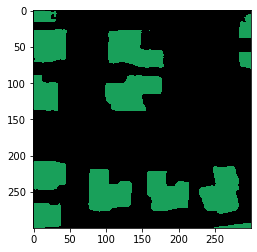

In [34]:
out = get_mask_preds(110, dataset_val)
plot_mask(out[0], out[1]) # pretrained

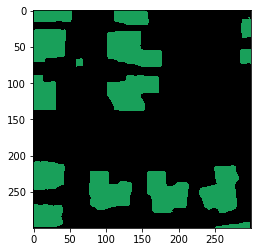

In [44]:
out = get_mask_preds(110, dataset_val)
plot_mask(out[0], out[1]) # 15

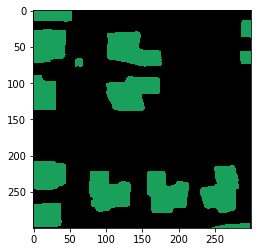

In [29]:
out = get_mask_preds(110, dataset_val)
plot_mask(out[0], out[1]) # 30

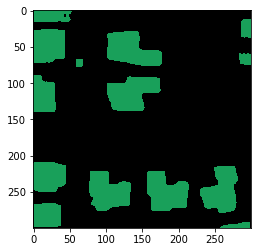

In [49]:
out = get_mask_preds(110, dataset_val)
plot_mask(out[0], out[1]) # 45

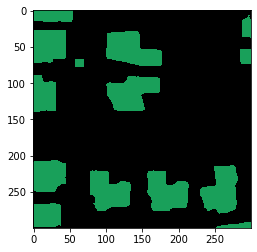

In [13]:
out = get_mask_preds(110, dataset_val)
plot_mask(out[0], out[1]) # 90

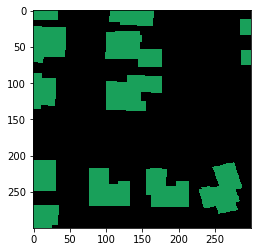

In [12]:
out = dataset_val.load_mask(110)
plot_mask(out[0], ['building' for _ in range(out[0].shape[-1])])

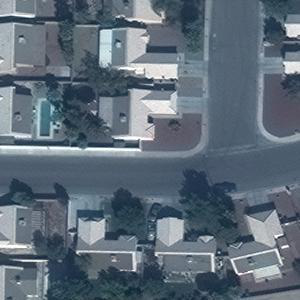

In [35]:
Image.open(dataset_val.image_info[110]['path'])

In [23]:
im = Image.open('osm_images/tmp5.PNG')
im = im.resize((320,320), Image.ANTIALIAS)

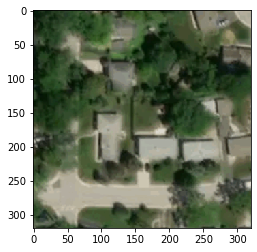

In [24]:
plt.imshow(np.array(im)[:,:,:3])

In [16]:
import imageio

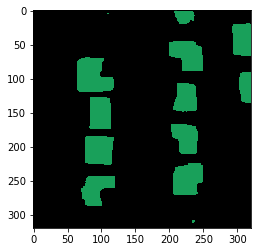

In [35]:
im = Image.open('osm_images/tmp.PNG')
im = im.resize((320,320), Image.ANTIALIAS)
out = model.detect([imageio.core.util.Array(np.array(im)[:,:,:3])])
plot_mask(out[0]['masks'], ['building' for _ in range(out[0]['masks'].shape[-1])]) # pretrained

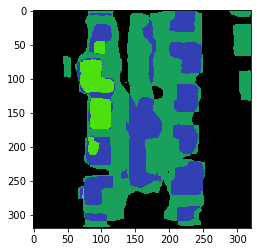

In [45]:
im = Image.open('osm_images/tmp.PNG')
im = im.resize((320,320), Image.ANTIALIAS)
out = model.detect([imageio.core.util.Array(np.array(im)[:,:,:3])])
plot_mask(out[0]['masks'], ['building' for _ in range(out[0]['masks'].shape[-1])]) # 15

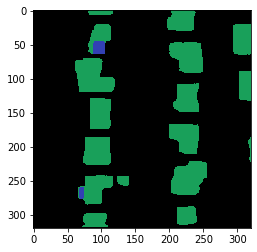

In [30]:
im = Image.open('osm_images/tmp.PNG')
im = im.resize((320,320), Image.ANTIALIAS)
out = model.detect([imageio.core.util.Array(np.array(im)[:,:,:3])])
plot_mask(out[0]['masks'], ['building' for _ in range(out[0]['masks'].shape[-1])]) # 30

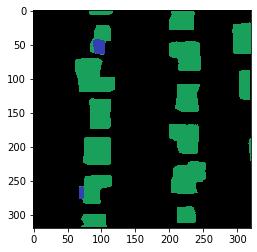

In [50]:
im = Image.open('osm_images/tmp.PNG')
im = im.resize((320,320), Image.ANTIALIAS)
out = model.detect([imageio.core.util.Array(np.array(im)[:,:,:3])])
plot_mask(out[0]['masks'], ['building' for _ in range(out[0]['masks'].shape[-1])]) # 45

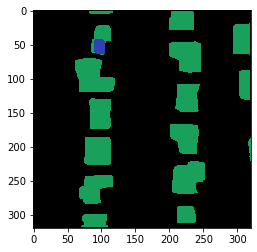

In [61]:
im = Image.open('osm_images/tmp.PNG')
im = im.resize((320,320), Image.ANTIALIAS)
out = model.detect([imageio.core.util.Array(np.array(im)[:,:,:3])])
plot_mask(out[0]['masks'], ['building' for _ in range(out[0]['masks'].shape[-1])]) # 50

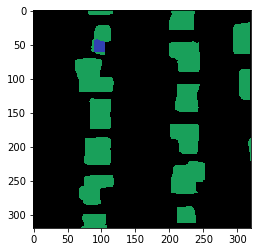

In [64]:
im = Image.open('osm_images/tmp.PNG')
im = im.resize((320,320), Image.ANTIALIAS)
out = model.detect([imageio.core.util.Array(np.array(im)[:,:,:3])])
plot_mask(out[0]['masks'], ['building' for _ in range(out[0]['masks'].shape[-1])]) # 55

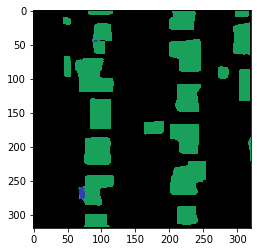

In [71]:
im = Image.open('osm_images/tmp.PNG')
im = im.resize((320,320), Image.ANTIALIAS)
out = model.detect([imageio.core.util.Array(np.array(im)[:,:,:3])])
plot_mask(out[0]['masks'], ['building' for _ in range(out[0]['masks'].shape[-1])]) # 60

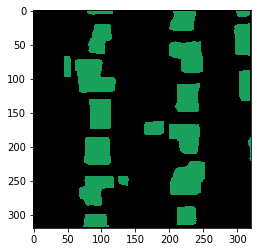

In [25]:
im = Image.open('osm_images/tmp.PNG')
im = im.resize((320,320), Image.ANTIALIAS)
out = model.detect([imageio.core.util.Array(np.array(im)[:,:,:3])])
plot_mask(out[0]['masks'], ['building' for _ in range(out[0]['masks'].shape[-1])]) # 90

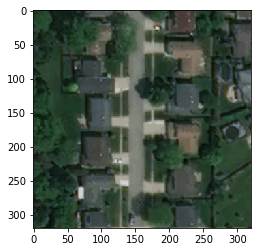

In [62]:
plt.imshow(im)

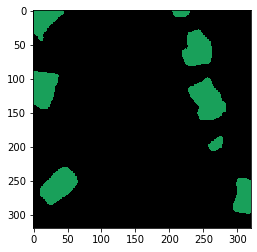

In [36]:
im = Image.open('osm_images/tmp4.PNG')
im = im.resize((320,320), Image.ANTIALIAS)
out = model.detect([imageio.core.util.Array(np.array(im)[:,:,:3])])
plot_mask(out[0]['masks'], ['building' for _ in range(out[0]['masks'].shape[-1])]) # pretrained

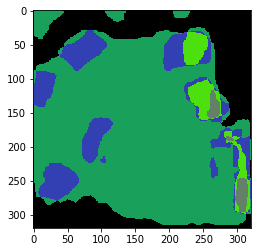

In [46]:
im = Image.open('osm_images/tmp4.PNG')
im = im.resize((320,320), Image.ANTIALIAS)
out = model.detect([imageio.core.util.Array(np.array(im)[:,:,:3])])
plot_mask(out[0]['masks'], ['building' for _ in range(out[0]['masks'].shape[-1])]) # 15

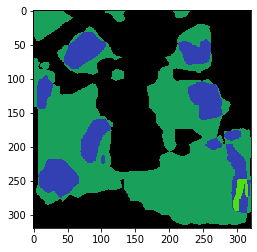

In [31]:
im = Image.open('osm_images/tmp4.PNG')
im = im.resize((320,320), Image.ANTIALIAS)
out = model.detect([imageio.core.util.Array(np.array(im)[:,:,:3])])
plot_mask(out[0]['masks'], ['building' for _ in range(out[0]['masks'].shape[-1])]) # 30

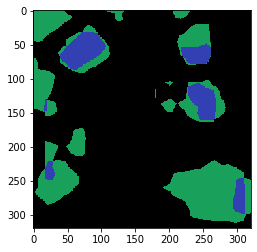

In [51]:
im = Image.open('osm_images/tmp4.PNG')
im = im.resize((320,320), Image.ANTIALIAS)
out = model.detect([imageio.core.util.Array(np.array(im)[:,:,:3])])
plot_mask(out[0]['masks'], ['building' for _ in range(out[0]['masks'].shape[-1])]) # 45

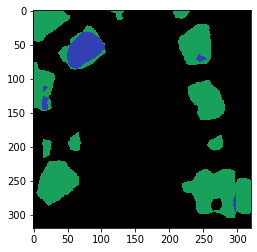

In [59]:
im = Image.open('osm_images/tmp4.PNG')
im = im.resize((320,320), Image.ANTIALIAS)
out = model.detect([imageio.core.util.Array(np.array(im)[:,:,:3])])
plot_mask(out[0]['masks'], ['building' for _ in range(out[0]['masks'].shape[-1])]) # 50

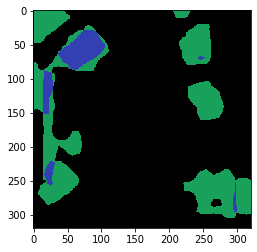

In [65]:
im = Image.open('osm_images/tmp4.PNG')
im = im.resize((320,320), Image.ANTIALIAS)
out = model.detect([imageio.core.util.Array(np.array(im)[:,:,:3])])
plot_mask(out[0]['masks'], ['building' for _ in range(out[0]['masks'].shape[-1])]) # 55

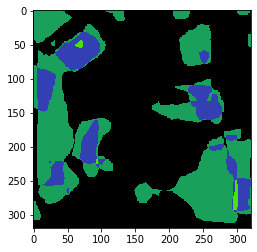

In [74]:
im = Image.open('osm_images/tmp4.PNG')
im = im.resize((320,320), Image.ANTIALIAS)
out = model.detect([imageio.core.util.Array(np.array(im)[:,:,:3])])
plot_mask(out[0]['masks'], ['building' for _ in range(out[0]['masks'].shape[-1])]) # 60

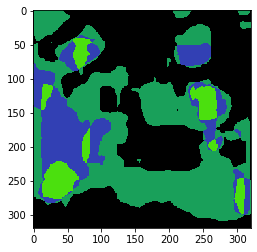

In [26]:
im = Image.open('osm_images/tmp4.PNG')
im = im.resize((320,320), Image.ANTIALIAS)
out = model.detect([imageio.core.util.Array(np.array(im)[:,:,:3])])
plot_mask(out[0]['masks'], ['building' for _ in range(out[0]['masks'].shape[-1])]) # 90

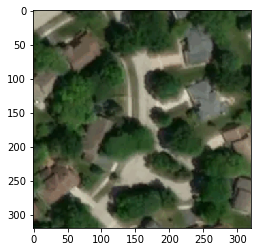

In [60]:
plt.imshow(im)

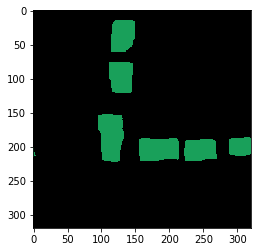

In [38]:
im = Image.open('osm_images/tmp5.PNG')
im = im.resize((320,320), Image.ANTIALIAS)
out = model.detect([imageio.core.util.Array(np.array(im)[:,:,:3])])
plot_mask(out[0]['masks'], ['building' for _ in range(out[0]['masks'].shape[-1])]) # pretrained

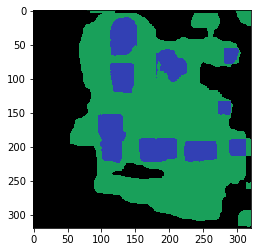

In [47]:
im = Image.open('osm_images/tmp5.PNG')
im = im.resize((320,320), Image.ANTIALIAS)
out = model.detect([imageio.core.util.Array(np.array(im)[:,:,:3])])
plot_mask(out[0]['masks'], ['building' for _ in range(out[0]['masks'].shape[-1])]) # 15

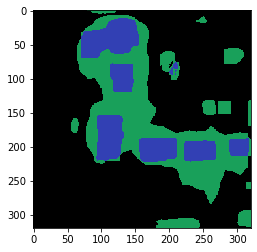

In [32]:
im = Image.open('osm_images/tmp5.PNG')
im = im.resize((320,320), Image.ANTIALIAS)
out = model.detect([imageio.core.util.Array(np.array(im)[:,:,:3])])
plot_mask(out[0]['masks'], ['building' for _ in range(out[0]['masks'].shape[-1])]) # 30

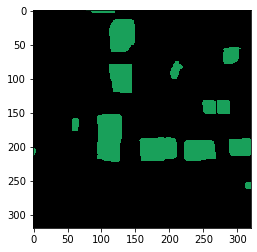

In [52]:
im = Image.open('osm_images/tmp5.PNG')
im = im.resize((320,320), Image.ANTIALIAS)
out = model.detect([imageio.core.util.Array(np.array(im)[:,:,:3])])
plot_mask(out[0]['masks'], ['building' for _ in range(out[0]['masks'].shape[-1])]) # 45

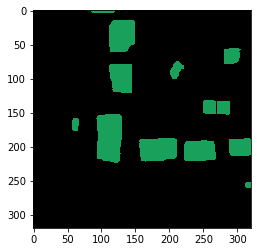

In [57]:
im = Image.open('osm_images/tmp5.PNG')
im = im.resize((320,320), Image.ANTIALIAS)
out = model.detect([imageio.core.util.Array(np.array(im)[:,:,:3])])
plot_mask(out[0]['masks'], ['building' for _ in range(out[0]['masks'].shape[-1])]) # 50

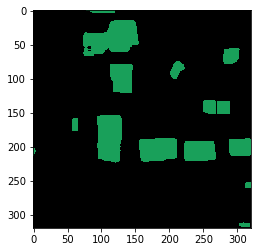

In [66]:
im = Image.open('osm_images/tmp5.PNG')
im = im.resize((320,320), Image.ANTIALIAS)
out = model.detect([imageio.core.util.Array(np.array(im)[:,:,:3])])
plot_mask(out[0]['masks'], ['building' for _ in range(out[0]['masks'].shape[-1])]) # 55

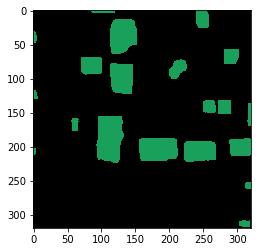

In [73]:
im = Image.open('osm_images/tmp5.PNG')
im = im.resize((320,320), Image.ANTIALIAS)
out = model.detect([imageio.core.util.Array(np.array(im)[:,:,:3])])
plot_mask(out[0]['masks'], ['building' for _ in range(out[0]['masks'].shape[-1])]) # 60

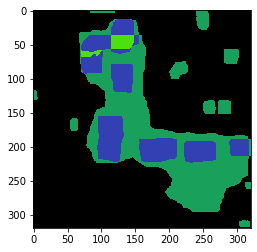

In [27]:
im = Image.open('osm_images/tmp5.PNG')
im = im.resize((320,320), Image.ANTIALIAS)
out = model.detect([imageio.core.util.Array(np.array(im)[:,:,:3])])
plot_mask(out[0]['masks'], ['building' for _ in range(out[0]['masks'].shape[-1])]) # 90

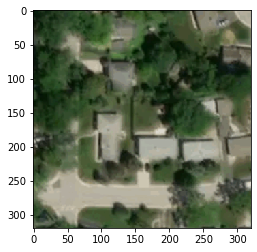

In [58]:
plt.imshow(im.resize(320,))

In [10]:
def get_mask_preds(im_id, dataset):
    tmp = model.detect([dataset.load_image(im_id)])
    
    h,w = dataset.image_info[im_id]['height'], dataset.image_info[im_id]['width']
    divider = h*w
    building_masks = np.zeros((h,w)).astype(bool)
    building = False
    
    for i in range(len(tmp[0]['class_ids'])):
        cur_id = tmp[0]['class_ids'][i]
        cur_mask = tmp[0]['masks'][:,:,i]
        if cur_id == 1:
            building_masks += cur_mask.reshape((h,w))
            building = True
        else:
            print('ERROR: id not found')
            return

    if building:
        return building_masks[:,:,None], ['building']
    else:
        print('only predicted other')
        return None, None

In [11]:
import matplotlib.pyplot as plt

def plot_original(im_id, dataset):
    plt.imshow(dataset.load_image(im_id))

def plot_mask(masks, labels):
    if masks is None: # just an empty plot
        plt.imshow(np.zeros([512,512,3]).astype(np.uint8))
        return
    net_image = np.zeros([masks.shape[0],masks.shape[1],3])
    assert masks.shape[-1] == len(labels)
    for i in range(masks.shape[2]):
        m = masks[:,:,i].astype(np.uint8)[:,:,None]
        mask = np.append(m,m,axis=2)
        mask = np.append(mask,m,axis=2)
        if labels[i] == 'building':
            mask = mask * np.array([25,160,90]) # yellow for corn
        net_image += mask
    plt.imshow(net_image.astype(np.uint8))

# Evaluation

In [29]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 50 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 50)
APs = []
Ps = []
Rs = []

for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    Ps.append(precisions)
    Rs.append(recalls)

In [23]:
APs = np.array(APs)
np.mean(APs[~np.isnan(APs)])

0.8262977365009353

In [79]:
APs = np.array(APs)
np.mean(APs[~np.isnan(APs)])

0.8294116519542625

In [27]:
np.mean(APs)

0.844062734941454

In [28]:
np.mean(APs)

0.8108075287347156

In [25]:
np.mean(APs)

0.6415881043020073